In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl

# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../kaggle"))

import importlib
import graphs as g
import utils as u
import processing as p
import model as m
import selection as s

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [52]:
train_data = pd.read_csv('numerai_datasets/numerai_training_data.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393613 entries, 0 to 393612
Data columns (total 54 columns):
id           393613 non-null object
era          393613 non-null object
data_type    393613 non-null object
feature1     393613 non-null float64
feature2     393613 non-null float64
feature3     393613 non-null float64
feature4     393613 non-null float64
feature5     393613 non-null float64
feature6     393613 non-null float64
feature7     393613 non-null float64
feature8     393613 non-null float64
feature9     393613 non-null float64
feature10    393613 non-null float64
feature11    393613 non-null float64
feature12    393613 non-null float64
feature13    393613 non-null float64
feature14    393613 non-null float64
feature15    393613 non-null float64
feature16    393613 non-null float64
feature17    393613 non-null float64
feature18    393613 non-null float64
feature19    393613 non-null float64
feature20    393613 non-null float64
feature21    393613 non-null float64
feat

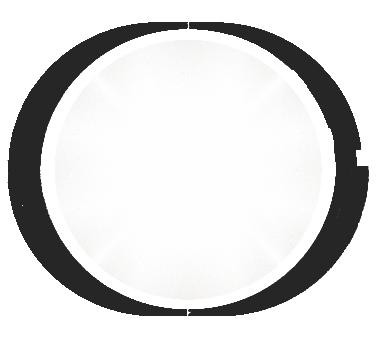

In [28]:
train_data['target'].plot.pie(figsize=(6, 6))

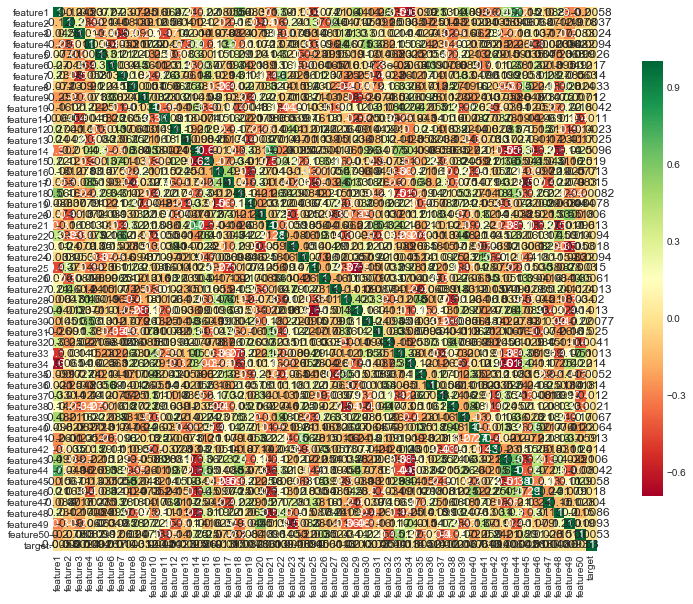

In [3]:
g.plot_correlation_map(train_data)

In [4]:
val_data = pd.read_csv('numerai_datasets/numerai_tournament_data.csv')
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243281 entries, 0 to 243280
Data columns (total 54 columns):
id           243281 non-null object
era          243281 non-null object
data_type    243281 non-null object
feature1     243281 non-null float64
feature2     243281 non-null float64
feature3     243281 non-null float64
feature4     243281 non-null float64
feature5     243281 non-null float64
feature6     243281 non-null float64
feature7     243281 non-null float64
feature8     243281 non-null float64
feature9     243281 non-null float64
feature10    243281 non-null float64
feature11    243281 non-null float64
feature12    243281 non-null float64
feature13    243281 non-null float64
feature14    243281 non-null float64
feature15    243281 non-null float64
feature16    243281 non-null float64
feature17    243281 non-null float64
feature18    243281 non-null float64
feature19    243281 non-null float64
feature20    243281 non-null float64
feature21    243281 non-null float64
feat

In [45]:
val_data.data_type.unique()

array(['validation', 'test', 'live'], dtype=object)

# Feature selection

In [5]:
features = [c for c in train_data.columns if c.startswith('feature')]
# features = ['feature10', 'feature19', 'feature6', 'feature15', 'feature7', 'feature33', 'feature34', 'feature43', 'feature44']

In [6]:
X_train = np.array(train_data[features])
y_train = np.array(train_data.target)
u.log('X train', X_train.shape)
u.log('y train', y_train.shape)

X train * (393613, 50) 
y train * (393613,) 


In [7]:
X_val = np.array(val_data[val_data['data_type'] == 'validation'][features])
y_val = np.array(val_data[val_data['data_type'] == 'validation'].target)
u.log('X val', X_val.shape)
u.log('y val', y_val.shape)

X val * (46362, 50) 
y val * (46362,) 


In [10]:
X_val

array([[0.62378, 0.4786 , 0.51851, ..., 0.541  , 0.54293, 0.39146],
       [0.6744 , 0.31725, 0.3493 , ..., 0.60157, 0.52996, 0.81527],
       [0.54569, 0.45464, 0.2304 , ..., 0.58436, 0.37221, 0.48499],
       ...,
       [0.42452, 0.42687, 0.53941, ..., 0.64659, 0.656  , 0.57344],
       [0.50036, 0.57678, 0.3678 , ..., 0.82339, 0.57639, 0.40459],
       [0.40666, 0.4598 , 0.31474, ..., 0.72755, 0.58494, 0.48628]])

# Keras

In [19]:
importlib.reload(m)
from keras import optimizers as o
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model = m.keras_single_classification(X_train.shape[1])
model.compile(loss='binary_crossentropy', optimizer=o.RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=1000)

result = model.evaluate(X_val, y_val, verbose=1)
print('')
u.log(model.metrics_names, result)

# plt.figure(figsize=(12,8))
# g.plot_loss(history)
# g.plot_accuracy(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_27 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               5100      
_________________________________________________________________
activation_28 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 25)                2525      
_________________________________________________________________
activation_29 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 26        
__________

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [54]:
X_test = np.array(val_data[features])
u.log('X test', X_test.shape)

X test * (243281, 50) 


# XGB

In [ ]:
import xgboost as xgb
import operator

xgbc = xgb.XGBClassifier(learning_rate=0.01, n_estimators=50, silent=False)
xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='logloss', verbose=True)

xgb.plot_importance(xgbc)

# Prediction

In [60]:
y_test = model.predict(X_test)
u.log('Predictions', y_test.shape)

Predictions * (243281, 1) 


# Submission

In [63]:
sample = pd.read_csv('numerai_datasets/predictions.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['id', 'probability'])
submission.id = sample.id
submission.probability = y_test
submission.info()

submission.to_csv('submission.csv', index=False)

(243281, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243281 entries, 0 to 243280
Data columns (total 2 columns):
id             243281 non-null object
probability    243281 non-null float32
dtypes: float32(1), object(1)
memory usage: 2.8+ MB
